### Motivation and description

To better understand this feature, we should put ourselves in the shoes of a Scrabble player who is analyzing a game.
As a Scrabble player who wants to improve, I would like to know how various plays I am considering affect my potential win percentage.

I can examine this statically:

- For example, I am currently 10 pts ahead of my opponent, there are 30 tiles in the bag, and it is my turn. What is my current / baseline win%?

Or I can think about this with respect to various plays I am considering:

- I am 10 pts ahead of my opponent, there are 30 tiles in the bag, and I am considering two plays. If I look ahead two plies (i.e., I make a play, my opponent replies, and I draw something to my leave, and play the best static play from there), I will be X points ahead (or behind) with Y tiles in the bag, and my opponent will be on turn. What is my win % after these events?

Now, if we generate millions of games and record for every turn in every game, how many pts the _player on turn_ was ahead or behind, and how many tiles are in the bag, _prior_ to making the turn, and whether the game was won or lost for that player, we can call this dataset WP.

With WP, we can answer question 1 - we look up in WP the data point corresponding to 10 pts ahead of my opponent, with 30 tiles in the bag. I have not made my turn yet, and without knowledge of my rack, my expected win % is whatever the dataset says.

We can also answer question 2. We look up in WP the data point corresponding to X pts ahead (or behind) my opponent, with Y tiles in the bag. In this case, my opponent is on turn, so after we look up the data for this particular point (X, Y), let's call it _Ω_, we can compute 1 - _Ω_ to get the win percentage for myself.

In [181]:
# Created during May 25 HACKATHON by JD

# Calculates win percentage given on game score for both players.

In [182]:
from copy import deepcopy
import csv
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

log_files = [
    '/home/cesar/data/autogenerated-data/20220823/autogenerate_20220823_autoplay_5.csv',   # a CSW21 set
    '/home/cesar/data/autogenerated-data/20220824/autogenerate_20220825_autoplay_3.csv']   # a NWL20 set

todays_date = date.today().strftime("%Y%m%d")
pd.options.display.max_rows = 999


In [183]:
spread = {}
win_dict = {}

t0 = time.time()

# because moves are logged chronologically, we can overwrite the entry for each game ID
# for each move until we reach the final move, at which point we know the final state of the game.
for log_file in log_files:
    with open(log_file,'r') as f:
        moveReader = csv.reader(f)
        next(moveReader)

        for i,row in enumerate(moveReader):
            if (i+1)%1000000==0:
                print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

            if i<10:
                print(row)

            # This flag indicates whether p1 won or not, with 0.5 as the value if the game was tied.
            if row[0]=='p1':
                spread[row[1]] = int(row[6])-int(row[11])
            else:
                spread[row[1]] = int(row[11])-int(row[6])
            

['p1', '6305d312010f678f3a000001', '1', 'AAAEKOT', ' 8C AKATEA', '30', '30', '6', 'O', '27.504', '86', '0']
['p1', '6305d312010f678f3a000002', '1', 'CEHNOOT', ' 8C THEOCON', '82', '82', '7', '', '82.000', '86', '0']
['p2', '6305d312010f678f3a000005', '1', 'EEEIMSU', ' 8H EMEU', '12', '12', '4', 'EIS', '25.680', '86', '0']
['p2', '6305d312010f678f3a000006', '1', 'EFOORRT', ' 8D FOOTER', '26', '26', '6', 'R', '27.928', '86', '0']
['p2', '6305d312010f678f3a000002', '2', 'CDLLOTY', ' E4 CLOY.D', '24', '24', '5', 'LT', '22.888', '79', '82']
['p2', '6305d312010f678f3a000007', '1', 'EINNRRT', ' 8D TINNER', '14', '14', '6', 'R', '15.928', '86', '0']
['p1', '6305d312010f678f3a000003', '1', 'CGINOPS', ' 8D COPSING', '80', '80', '7', '', '80.000', '86', '0']
['p1', '6305d312010f678f3a000004', '1', 'ADENORR', ' 8C ADORNER', '70', '70', '7', '', '69.300', '86', '0']
['p2', '6305d312010f678f3a000001', '2', 'ACHINOZ', ' F4 HOAC.ZIN', '76', '76', '7', '', '76.000', '80', '30']
['p2', '6305d312010f678f

Processed 27000000 rows in 103.87875127792358 seconds
Processed 28000000 rows in 104.7691662311554 seconds
Processed 29000000 rows in 105.65897798538208 seconds
Processed 30000000 rows in 106.56185746192932 seconds
Processed 31000000 rows in 107.46151757240295 seconds
Processed 32000000 rows in 108.3598906993866 seconds
Processed 33000000 rows in 109.2513861656189 seconds
Processed 34000000 rows in 110.15540266036987 seconds
Processed 35000000 rows in 111.0514748096466 seconds
Processed 36000000 rows in 111.9732301235199 seconds
Processed 37000000 rows in 113.02806687355042 seconds
Processed 38000000 rows in 113.92103815078735 seconds
Processed 39000000 rows in 114.80539107322693 seconds
Processed 40000000 rows in 115.696861743927 seconds
Processed 41000000 rows in 116.58539175987244 seconds
Processed 42000000 rows in 117.477055311203 seconds
Processed 43000000 rows in 118.36870956420898 seconds
Processed 44000000 rows in 119.25900912284851 seconds
Processed 45000000 rows in 120.151311

Can define what spread beyond which you assume player has a 0 or 100% chance of winning - using 300 as first guess.

Also, spreads now range only from 0 to positive numbers, because trailing by 50 and winning is the same outcome and leading by 50 and losing (just swapping the players' perspectives)

In [184]:
for game_id in spread.keys():
    win_dict[game_id] = (np.sign(spread[game_id])+1)/2
    
# win_dict is always from the perspective of p1

In [185]:
max_spread = 300
counter_dict_by_spread_and_tiles_remaining = {x:{
    spread:0 for spread in range(max_spread,-max_spread-1,-1)} for x in range(0,94)}
win_counter_dict_by_spread_and_tiles_remaining = deepcopy(counter_dict_by_spread_and_tiles_remaining)


t0=time.time()
MAX_RACK_TILES = 7
print('There are {} games'.format(len(win_dict)))
last_evt = {}

for log_file in log_files:
    with open(log_file,'r') as f:
        moveReader = csv.reader(f)
        next(moveReader)
        
        # use this instead of DictReader because array access is much faster.
        GAME_ID = 1
        PLAYER_ID = 0
        PLAY = 4
        SCORE = 5
        TOTAL_SCORE = 6
        TILES_PLAYED = 7
        LEAVE = 8
        TILES_REMAINING = 10 
        OPP_SCORE = 11
        
        for i,row in enumerate(moveReader):
            if (i+1)%1000000==0:
                print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

            # truncate spread to the range -max_spread to max_spread
            # tiles in bag at the beginning of turn, minus tiles used, plus tiles in opponent's rack.
            if row[GAME_ID] in last_evt:
                last_row = last_evt[row[GAME_ID]]
                if int(last_row[TILES_REMAINING]) == 0:
                    # The bag might be empty. The opponent has their last leave in their rack + the number of tiles
                    # in the bag. See this sequence of moves to understand.
                    # playerID,gameID,turn,rack,play,score,totalscore,tilesplayed,leave,equity,tilesremaining,oppscore
                    # p2,6305d312010f678f3a000001,16,AEEEFSV, H1 FAVES.,39,342,5,EE,38.555,10,337
                    # p1,6305d312010f678f3a000001,17,GHMOQST,L11 MO.TH,28,365,4,GQS,17.622,5,342
                    # p2,6305d312010f678f3a000001,18,AEEILOU,K10 EUO.,22,364,3,AEIL,28.010,1,365
                    # p1,6305d312010f678f3a000001,19,AEGGIQS, M9 QIS,28,393,3,AEGG,6.000,0,364
                    # p2,6305d312010f678f3a000001,20,AEILN,15J IN.ALE,27,403,5,,39.000,0,393
                    # p2 played FAVES. keeping EE, and there were 10 tiles in the bag. So they draw 5 of them to
                    # p1 played MO.TH keeping GQS, and there were 5 tiles in the bag. So they draw 4 of them to
                    # make 7 again. 
                    # p2 played EUO. keeping AEIL, and there was 1 tile in the bag. They draw the last tile, and
                    # now have 5 in their rack.
                    # p1 played QIS keeping AEGG. There are no more tiles to draw, so they have 4 in their rack.
                    # p2 went out with IN.ALE.
                    
                    # what is the number of tiles my opponent has, before i start my turn?
                    num_tiles_in_opp_rack = min(len(last_row[LEAVE]) + int(last_row[TILES_REMAINING]), MAX_RACK_TILES)
            else:
                num_tiles_in_opp_rack = MAX_RACK_TILES
            # example of an exchange:
            # p2,6305d5d1010f678f3a064aef,17,EGOSUUU,(exch GOUUU),0,277,2,ES,11.954,14,322
            tilesplayed = int(row[TILES_PLAYED])
            if row[PLAY].startswith('(exch'):
                # Since exchanged tiles aren't played on the board, they should count as unseen
                # (back in the bag)
                tilesplayed = 0
            
            start_turn_tiles_unseen = int(row[TILES_REMAINING])+ num_tiles_in_opp_rack
            score_before_play = int(row[TOTAL_SCORE]) - int(row[SCORE])
            oppscore = int(row[OPP_SCORE])
            start_turn_spread = min(max(score_before_play - oppscore, -max_spread), max_spread)

            # we now have a start_turn_spread and a start_turn_tiles_unseen from the pov of the player whose
            # turn it currently is.
            
            
            if start_turn_tiles_unseen > 0:
                counter_dict_by_spread_and_tiles_remaining[start_turn_tiles_unseen][start_turn_spread] += 1

                # p1 is the player for whom we have calculated whether the games in win_dict are wins or losses
                if row[PLAYER_ID]=='p1':
                    win_counter_dict_by_spread_and_tiles_remaining[
                        start_turn_tiles_unseen][start_turn_spread] += (win_dict[row[GAME_ID]])
                else:
                    win_counter_dict_by_spread_and_tiles_remaining[
                        start_turn_tiles_unseen][start_turn_spread] += 1-win_dict[row[GAME_ID]]

            last_evt[row[GAME_ID]] = row
                    
            # debug rows
            if i<10:
                print(row)
                print(start_turn_spread)
                print(start_turn_tiles_unseen)
                print(counter_dict_by_spread_and_tiles_remaining[start_turn_tiles_unseen][start_turn_spread])
                print(win_counter_dict_by_spread_and_tiles_remaining[start_turn_tiles_unseen][start_turn_spread])

There are 8000000 games
['p1', '6305d312010f678f3a000001', '1', 'AAAEKOT', ' 8C AKATEA', '30', '30', '6', 'O', '27.504', '86', '0']
0
93
1
0.0
['p1', '6305d312010f678f3a000002', '1', 'CEHNOOT', ' 8C THEOCON', '82', '82', '7', '', '82.000', '86', '0']
0
93
2
1.0
['p2', '6305d312010f678f3a000005', '1', 'EEEIMSU', ' 8H EMEU', '12', '12', '4', 'EIS', '25.680', '86', '0']
0
93
3
2.0
['p2', '6305d312010f678f3a000006', '1', 'EFOORRT', ' 8D FOOTER', '26', '26', '6', 'R', '27.928', '86', '0']
0
93
4
2.0
['p2', '6305d312010f678f3a000002', '2', 'CDLLOTY', ' E4 CLOY.D', '24', '24', '5', 'LT', '22.888', '79', '82']
-82
86
1
0.0
['p2', '6305d312010f678f3a000007', '1', 'EINNRRT', ' 8D TINNER', '14', '14', '6', 'R', '15.928', '86', '0']
0
93
5
2.0
['p1', '6305d312010f678f3a000003', '1', 'CGINOPS', ' 8D COPSING', '80', '80', '7', '', '80.000', '86', '0']
0
93
6
3.0
['p1', '6305d312010f678f3a000004', '1', 'ADENORR', ' 8C ADORNER', '70', '70', '7', '', '69.300', '86', '0']
0
93
7
3.0
['p2', '6305d312010f

Processed 20000000 rows in 219.76917433738708 seconds
Processed 21000000 rows in 221.76525259017944 seconds
Processed 22000000 rows in 223.7610411643982 seconds
Processed 23000000 rows in 225.76178741455078 seconds
Processed 24000000 rows in 229.5886790752411 seconds
Processed 25000000 rows in 231.5839228630066 seconds
Processed 26000000 rows in 233.58026480674744 seconds
Processed 27000000 rows in 235.57403254508972 seconds
Processed 28000000 rows in 237.57758688926697 seconds
Processed 29000000 rows in 239.5785801410675 seconds
Processed 30000000 rows in 241.5740659236908 seconds
Processed 31000000 rows in 243.57434368133545 seconds
Processed 32000000 rows in 245.5745084285736 seconds
Processed 33000000 rows in 247.57373642921448 seconds
Processed 34000000 rows in 249.57357382774353 seconds
Processed 35000000 rows in 251.57586932182312 seconds
Processed 36000000 rows in 253.58269238471985 seconds
Processed 37000000 rows in 255.68050408363342 seconds
Processed 38000000 rows in 257.657

In [352]:
count_df = pd.DataFrame(counter_dict_by_spread_and_tiles_remaining)
win_df = pd.DataFrame(win_counter_dict_by_spread_and_tiles_remaining)
win_pct_df = (win_df/count_df)

In [353]:
win_pct_cp = win_pct_df.copy()
# win_pct_cp = win_pct_cp.rename_axis(mapper='spread', axis=0)
# win_pct_cp = win_pct_cp.rename_axis(mapper='tiles_remaining', axis=1)
win_pct_cp['spreadobs'] = win_pct_cp.index
regressed_win_pct = {x:{
    spread:0 for spread in range(max_spread,-max_spread-1,-1)} for x in range(0,94)}

In [358]:
# I have no idea why i have to do this nonsense with a grid, and why this works and not just a straight logit regression.
# doing a logit regression doesn't fit the curve as well.
# This code came from the seaborn library's regplot function and related code.
for tr in range(1, 93):
    grid = np.linspace(-max_spread, max_spread, 2*max_spread+1)
    grid = np.c_[np.ones(len(grid)), grid]
    x = win_pct_cp['spreadobs']
    y = win_pct_cp[tr]

    X = np.c_[np.ones(len(x)), x]


    log_reg = GLM(y, X, missing='drop', family=sm.families.Binomial()).fit()
    predWP = log_reg.predict(grid)
    for idx, val in enumerate(predWP):
        
        regressed_win_pct[tr][idx-max_spread] = val
    
    
# log_reg.summary()

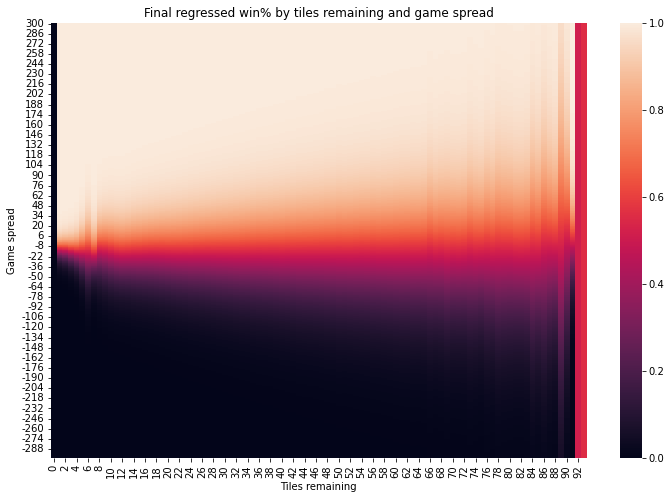

In [359]:
final_df = pd.DataFrame(regressed_win_pct)
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(final_df, ax=ax)
ax.set_xlabel('Tiles remaining')
ax.set_ylabel('Game spread')
ax.set_title('Final regressed win% by tiles remaining and game spread')

final_df.to_csv('regressed_winpct.csv', float_format='%.6f')

### Note the following imperfections:

- Edge condition at 0 and 92/93 tiles situation. It's not going to matter because 0 tiles unseen means the game is over, 92 tiles unseen is not a valid situation in Scrabble (1-tile plays are not acceptable), and 93 tiles left only works when the spread is 0. However, for ZOMGWords or similar these values will not be accurate for win%.
- The final data set is not monotonous. Note as we get to higher numbers of tiles remaining there are more prominent "vertical lines" because with less data the logistic regressions have different "slopes". 

### How to fix?

We should explore a nonparametric regression across both axes. I have no idea how to do this, however.

### Good enough?

This might still be good enough for ranking plays relative to each other.

In [387]:
final_df[30][40]

0.8559297158804463

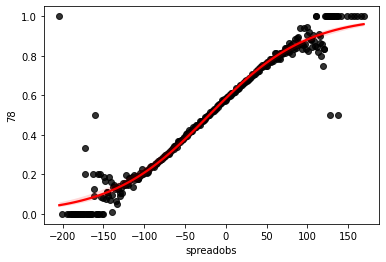

In [360]:
fig,ax=plt.subplots()
p = sns.regplot(x=win_pct_cp['spreadobs'], y=win_pct_cp[78], ax=ax, logistic=True, 
                data=win_pct_cp, scatter_kws={"color": "black"}, line_kws={"color": "red"})
# plt.savefig('regression_plot.png')

## Everything below this cell seems experimental --- IGNORE for now

In [ ]:
plt.savefig('win_pct.jpg')

In [ ]:
count_df.iloc[300:350,79:]

The 50% win line is likely a little bit above 0 spread, because when you end a turn with 0 spread, your opponent on average gets an extra half-turn more than you for the rest of the game. Let's find that line.

In [ ]:
win_pct_df.iloc[250:350,79:]

## Opening turn scores

In [ ]:
pd.options.display.max_rows = 999

## Apply smoothing
We want the win percentage to increase monotonically with spread, even though we have a limited sample size and this may not always be true. Therefore, we want to be able to average win percentages over neighboring scenarios (similar spread difference and similar # of tiles remaining).

In [ ]:
counter_dict_by_opening_turn_score = {x:0 for x in range(0,131)}
win_counter_dict_by_opening_turn_score = {x:0 for x in range(0,131)}
rows = []

In [ ]:
t0=time.time()
print('There are {} games'.format(len(win_dict)))

with open(log_file,'r') as f:
    moveReader = csv.reader(f)
    next(moveReader)
    
    for i,row in enumerate(moveReader):
        if (i+1)%1000000==0:
            print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

        if row[2]=='1':
            counter_dict_by_opening_turn_score[int(row[5])] += 1
            
            # check which player went first
            if row[0]=='p1':
                win_counter_dict_by_opening_turn_score[int(row[5])] += win_dict[row[1]]
                rows.append([int(row[5]), win_dict[row[1]]])
            else:
                win_counter_dict_by_opening_turn_score[int(row[5])] += 1-win_dict[row[1]]
                rows.append([int(row[5]), 1-win_dict[row[1]]])

        
#         # debug rows
#         if i<10:
#             print(row)

In [ ]:
tst_df=pd.DataFrame(rows).rename(columns={0:'opening turn score',1:'win'})

In [ ]:
opening_turn_count = pd.Series(counter_dict_by_opening_turn_score)
opening_turn_win_count = pd.Series(win_counter_dict_by_opening_turn_score)
opening_turn_win_pct = opening_turn_win_count/opening_turn_count

In [ ]:
tst = opening_turn_win_pct.dropna()

In [ ]:
opening_turn_win_pct

In [ ]:
fig,ax=plt.subplots()
plt.plot(tst)
plt.savefig('plot1.png')

In [ ]:
fig,ax=plt.subplots()
sns.regplot(x='opening turn score',y='win',data=tst_df,x_estimator=np.mean,ax=ax)
plt.savefig('regression_plot.png')

In [ ]:
fig,ax=plt.subplots()
sns.regplot(x='opening turn score',y='win',data=tst_df,x_estimator=np.mean,ax=ax,fit_reg=False)
plt.savefig('regression_plot_no_fitline.png')